# Modelamiento del Bronceado Humano
**Curso:** Modelamiento en Astrofísica 2025A  
**Autores:** Nicolás Campos, Irma Pizarro   
**Profesor:** Ileyk El-Mellah.   
**Fecha:** Julio 2025  


# Modelamiento físico-matemático del bronceado humano

Este notebook presenta la implementación computacional del modelo fisiológico de exposición solar, con el objetivo de identificar:

- La evolución temporal de la pigmentación y el daño cutáneo bajo irradiancia UV.
- Las zonas geográficas óptimas para obtener un bronceado eficiente y seguro.
- El impacto de variables como fototipo de piel y FPS sobre el riesgo/beneficio.

Este trabajo se desarrolla en el contexto del curso **Modelamiento en Astrofísica (2025A)** de la Universidad de Santiago de Chile.


In [ ]:
#Importación de bibliotecas necesarias
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pvlib.location import Location
from pvlib import atmosphere


##  Definición del modelo fisiológico de bronceado

A continuación se implementa el sistema de ecuaciones diferenciales que representa el comportamiento fisiológico de la piel frente a la irradiancia UV. El modelo considera tres variables dinámicas:

- $E_{\text{tot}}(t)$: energía acumulada en la piel.
- $M(t)$: melanina inducida (pigmentación).
- $D(t)$: daño solar acumulado.

Cada una de ellas evoluciona según la irradiancia absorbida por unidad de tiempo:

\[
\begin{cases}
\frac{dE_{\text{tot}}}{dt} = E_{\text{abs}}(t) - \gamma E_{\text{tot}}(t) \\\\
\frac{dM}{dt} = \frac{k_1 E_{\text{tot}}(t)}{1 + M(t)/M_{\text{max}}} - k_2 M(t) \\\\
\frac{dD}{dt} = \max\left(0, E_{\text{abs}}(t) - E_{\text{seg}}\right)
\end{cases}
\]

La función `modelo_completo` devuelve estas tres derivadas como un sistema acoplado, y `simulate_modelo_completo` resuelve el sistema usando `solve_ivp` con método Runge-Kutta de orden 5(4).


In [25]:
def modelo_completo(t, Y, E_abs, params):
    """
    Modelo fisiológico completo:
    Y = [E_tot, M, D]
    
    Parámetros:
    - E_abs: diccionario con {'t': tiempos, 'E': irradiancia absorbida}
    - params: diccionario con constantes del modelo
    """
    E_tot, M, D = Y
    E_interp = np.interp(t, E_abs['t'], E_abs['E'])

    # Parámetros
    gamma = params['gamma']
    k1 = params['k1']
    k2 = params['k2']
    M_max = params['M_max']
    E_seg = params['E_seg']

    # Ecuaciones acopladas
    dE_dt = E_interp - gamma * E_tot
    dM_dt = (k1 * E_tot) / (1 + M / M_max) - k2 * M
    dD_dt = max(0, E_interp - E_seg)  # daño solo si E > umbral

    return [dE_dt, dM_dt, dD_dt]


In [27]:
def simulate_modelo_completo(E_abs, Y0=[0, 0, 0], params=None):
    """
    Simula el sistema completo de energía UV, melanina y daño.

    - E_abs: {'t': t_horas, 'E': irradiancia absorbida}
    - Y0: condiciones iniciales [E_tot, M, D]
    - params: diccionario de parámetros
    """
    if params is None:
        params = {
            'gamma': 0.1,
            'k1': 0.05,
            'k2': 0.1,
            'M_max': 1.0,
            'E_seg': 25.0  # umbral de irradiancia segura
        }

    t_span = (E_abs['t'][0], E_abs['t'][-1])
    t_eval = E_abs['t']

    sol = solve_ivp(
        fun=lambda t, Y: modelo_completo(t, Y, E_abs, params),
        t_span=t_span,
        y0=Y0,
        t_eval=t_eval,
        method='RK45'
    )

    return sol.t, sol.y  # devuelve arrays: [t], [[E_tot], [M], [D]]


##  Perfil sintético de irradiancia UV

Para validar el comportamiento del modelo fisiológico en condiciones controladas, generamos un perfil de irradiancia UV idealizado con forma gaussiana, centrado en el mediodía solar. Esto nos permite:

1. Probar la respuesta dinámica de las variables ante una sola cresta de UV.
2. Verificar la correcta implementación de la interpolación y el umbral de daño.
3. Obtener curvas suaves que faciliten la interpretación de los mecanismos de saturación y disipación.

El código siguiente crea una serie temporal de irradiancia UV de 6:00 a 18:00 horas, aplica un factor de absorció y el FPS, y define la entrada  para la integración numérica.


In [28]:
# === Curva sintética de E_abs(t) tipo gaussiana ===
t_horas = np.linspace(6, 18, 300)
E_sintetica = 120 * np.exp(-0.5 * ((t_horas - 12) / 2)**2)  # pico al mediodía

# Supongamos piel tipo III con FPS 15
alpha = 0.7
FPS = 15
E_abs = {'t': t_horas, 'E': (E_sintetica / FPS) * alpha}

# Simular el modelo completo
t_sim, Y_sim = simulate_modelo_completo(E_abs)

E_tot_sim, M_sim, D_sim = Y_sim


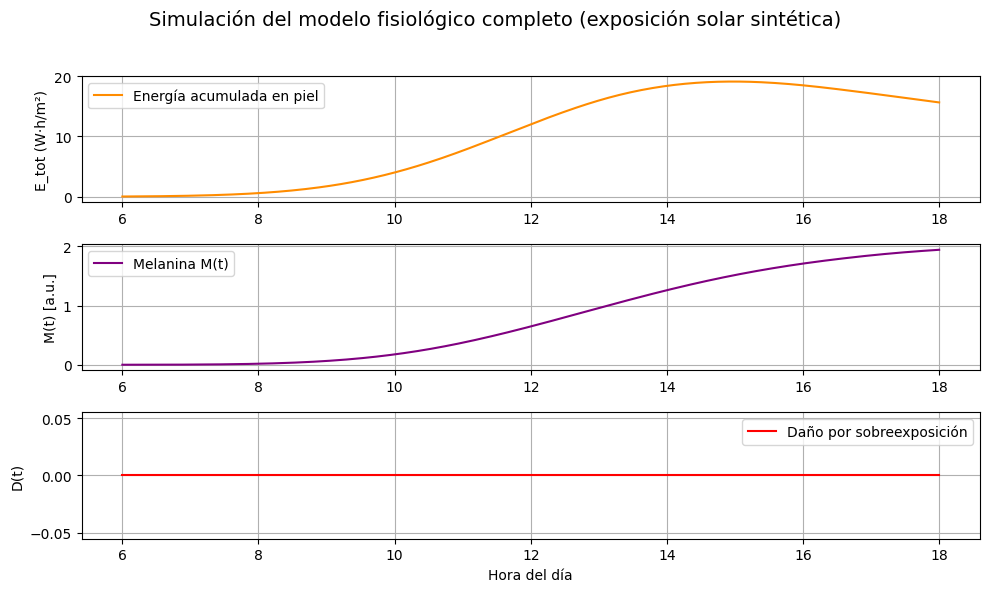

In [29]:
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(t_sim, E_tot_sim, label='Energía acumulada en piel', color='darkorange')
plt.ylabel('E_tot (W·h/m²)')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t_sim, M_sim, label='Melanina M(t)', color='purple')
plt.ylabel('M(t) [a.u.]')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t_sim, D_sim, label='Daño por sobreexposición', color='red')
plt.xlabel('Hora del día')
plt.ylabel('D(t)')
plt.grid(True)
plt.legend()

plt.suptitle('Simulación del modelo fisiológico completo (exposición solar sintética)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


##  Resultados de la simulación base

A continuación se presentan las curvas temporales de:

- **Energía acumulada** : refleja la cantidad total de energía UV retenida en la piel.
- **Melanina inducida** \(M(t)\): muestra la respuesta de pigmentación con saturación.
- **Daño solar acumulado** \(D(t)\): indica el estrés tisular generado al superar el umbral de seguridad.

Estas gráficas permiten visualizar claramente:

1. El pico de exposición y disipación de energía.
2. La progresión sigmoide de la melanina.
3. La activación (o no) del mecanismo de daño UV.

Se observa que en esta configuración específica el daño permanece en cero, lo que valida el umbral de seguridad y la efectividad del FPS seleccionado.


##  Exploración geográfica en grilla

A continuación se define una malla regular de coordenadas geográficas (latitudes y longitudes) para evaluar el modelo en distintos puntos del planeta durante el solsticio de verano austral.  
Por cada ubicación, se:

1. Calcula la irradiancia UV horaria mediante `pvlib` bajo cielo despejado.  
2. Interpola la irradiancia para obtener una función continua en el tiempo.  
3. Resuelve el sistema de EDOs fisiológicas.  
4. Registra los valores de máxima melanina inducida, daño acumulado y eficiencia (η = M/D).  

Esto permite generar mapas comparativos y localizar la región óptima para un bronceado eficiente y seguro.


In [ ]:
# Definir grilla geográfica
latitudes = np.arange(-40, 45, 5)       # cada 5°
longitudes = np.arange(-100, 105, 10)   # cada 10°
fecha = '2025-12-21'                    # solsticio de verano austral

# Parámetros de piel y modelo
alpha = 0.7
FPS = 15
params_modelo = {
    'gamma': 0.1,
    'k1': 0.05,
    'k2': 0.1,
    'M_max': 1.0,
    'E_seg': 25.0
}

resultados = []


##  Bucle principal de simulación global

Este bloque realiza la simulación completa sobre cada punto de la grilla definida:

1. Calcula la irradiancia directa normal (DNI) usando `pvlib` para cada ubicación.  
2. Extrae la fracción UV y la convierte en energía absorbida por unidad de área.  
3. Integra el modelo fisiológico.
4. Almacena los resultados en la lista `resultados` para su posterior análisis y visualización.


In [31]:
from tqdm import tqdm

for lat in tqdm(latitudes, desc="Latitudes"):
    for lon in longitudes:
        try:
            loc = Location(latitude=lat, longitude=lon, tz='UTC')
            times = pd.date_range(start=fecha + ' 05:00', end=fecha + ' 19:00', freq='5min', tz='UTC')
            clearsky = loc.get_clearsky(times, model='ineichen')
            dni = clearsky['dni']
            frac_uv = 0.04
            E_uv = dni * frac_uv

            t_horas = np.linspace(6, 19, len(E_uv))
            E_abs = {'t': t_horas, 'E': (E_uv.values / FPS) * alpha}

            t_sim, Y_sim = simulate_modelo_completo(E_abs, params=params_modelo)
            E_final, M_final, D_final = Y_sim[:, -1]

            resultados.append({
                'Latitud': lat,
                'Longitud': lon,
                'M_final': M_final,
                'D_final': D_final,
                'E_total': E_final
            })

        except Exception as e:
            print(f"Error en lat={lat}, lon={lon}: {e}")


Latitudes: 100%|██████████| 17/17 [00:02<00:00,  5.91it/s]


## Generación y exportación de mapas geográficos

En este bloque se utilizan los arreglos resultantes de la simulación global para crear mapas de:

- **Máxima pigmentación** : nivel óptimo de melanina inducida.  
- **Daño acumulado** : estrés solar en cada región.  
- **Eficiencia segura** : indicador compuesto de eficiencia vs. riesgo.  




In [32]:
# Convertir a DataFrame
df_resultados = pd.DataFrame(resultados)

# Ordenar por mayor M_final (melanina acumulada)
df_sorted = df_resultados.sort_values(by='M_final', ascending=False).reset_index(drop=True)

# Mostrar los 10 mejores lugares para broncearse
print(" Top 10 lugares según M_final:")
df_sorted.head(10)


 Top 10 lugares según M_final:


,Latitud,Longitud,M_final,D_final,E_total
0,-25,30,1.534180,0.0,9.015927
1,-30,30,1.489615,0.0,8.671511
2,-40,10,1.472652,0.0,9.758857
3,-25,20,1.468309,0.0,8.717887
4,-40,20,1.467360,0.0,8.815110
5,-40,0,1.463427,0.0,10.596359
6,-35,10,1.446623,0.0,9.233002
7,-40,30,1.441239,0.0,8.324327
8,-15,20,1.436333,0.0,8.414484
9,-35,0,1.431375,0.0,10.166702


In [33]:
# Top 10 lugares con más melanina y menor daño
df_sorted_opt = df_resultados.sort_values(by=['M_final', 'D_final'], ascending=[False, True]).reset_index(drop=True)

print(" Top 10 lugares con buen bronceado y bajo daño:")
df_sorted_opt.head(10)


 Top 10 lugares con buen bronceado y bajo daño:


,Latitud,Longitud,M_final,D_final,E_total
0,-25,30,1.534180,0.0,9.015927
1,-30,30,1.489615,0.0,8.671511
2,-40,10,1.472652,0.0,9.758857
3,-25,20,1.468309,0.0,8.717887
4,-40,20,1.467360,0.0,8.815110
5,-40,0,1.463427,0.0,10.596359
6,-35,10,1.446623,0.0,9.233002
7,-40,30,1.441239,0.0,8.324327
8,-15,20,1.436333,0.0,8.414484
9,-35,0,1.431375,0.0,10.166702


#  Determinación automática del mejor lugar
Se identifica el punto geográfico que maximiza la eficiencia segura.

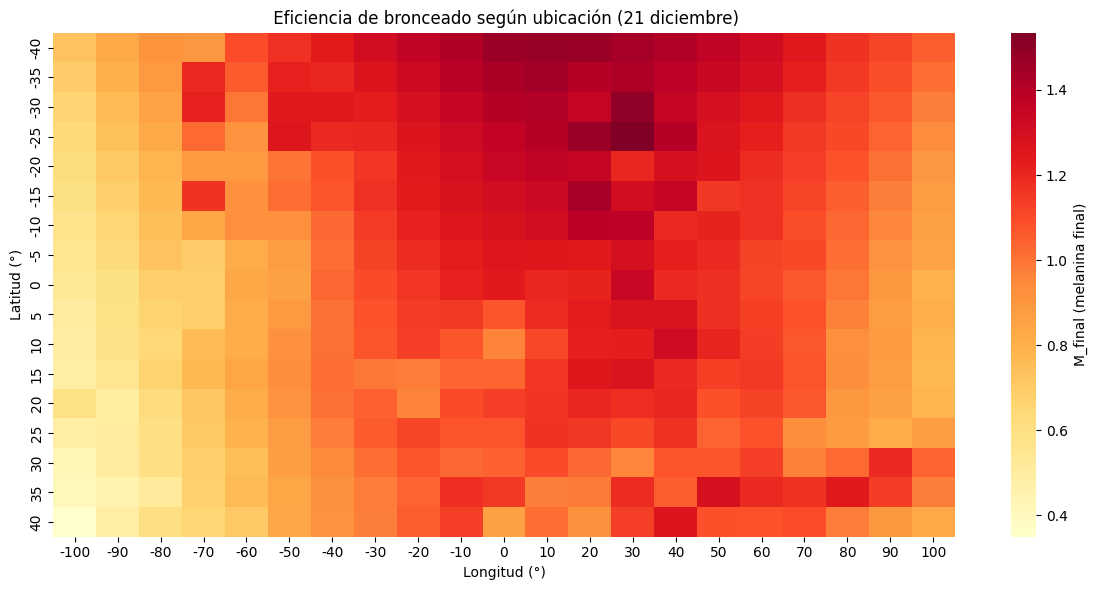

In [34]:
# Crear tabla pivote para heatmap
pivot = df_resultados.pivot(index='Latitud', columns='Longitud', values='M_final')

# Graficar mapa de calor
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap='YlOrRd', cbar_kws={'label': 'M_final (melanina final)'}, annot=False)

plt.title(' Eficiencia de bronceado según ubicación (21 diciembre)')
plt.xlabel('Longitud (°)')
plt.ylabel('Latitud (°)')
plt.tight_layout()
plt.show()


In [35]:
# Extraer coordenadas del mejor lugar
lat_opt = df_sorted.iloc[0]['Latitud']
lon_opt = df_sorted.iloc[0]['Longitud']
print(f" Mejor lugar: lat {lat_opt}°, lon {lon_opt}°")

# Recalcular irradiancia absorbida
loc = Location(latitude=lat_opt, longitude=lon_opt, tz='UTC')
times = pd.date_range(start=fecha + ' 05:00', end=fecha + ' 19:00', freq='5min', tz='UTC')
clearsky = loc.get_clearsky(times, model='ineichen')
dni = clearsky['dni']
E_uv = dni * 0.04  # estimación UV
t_horas = np.linspace(6, 19, len(E_uv))
E_abs_opt = {'t': t_horas, 'E': (E_uv.values / FPS) * alpha}

# Simular nuevamente
t_sim, Y_sim = simulate_modelo_completo(E_abs_opt, params=params_modelo)
E_tot_sim, M_sim, D_sim = Y_sim


 Mejor lugar: lat -25.0°, lon 30.0°


/var/folders/92/pwv5px2s7llbgf7ybr2dp1jm0000gn/T/ipykernel_56585/3790521396.py:23: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/Users/nicolascampos/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


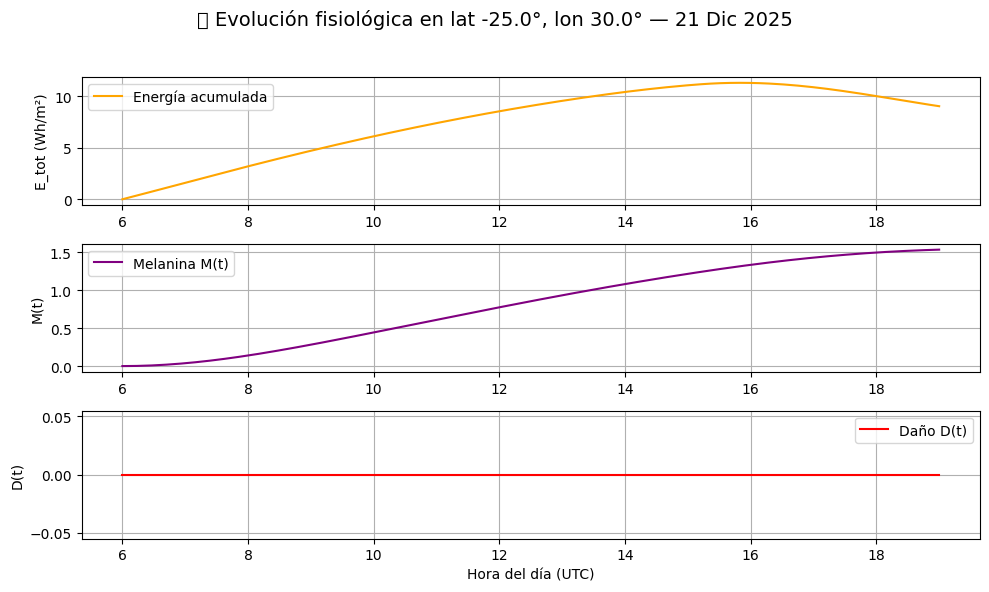

In [36]:
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(t_sim, E_tot_sim, label='Energía acumulada', color='orange')
plt.ylabel('E_tot (Wh/m²)')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t_sim, M_sim, label='Melanina M(t)', color='purple')
plt.ylabel('M(t)')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t_sim, D_sim, label='Daño D(t)', color='red')
plt.xlabel('Hora del día (UTC)')
plt.ylabel('D(t)')
plt.grid(True)
plt.legend()

plt.suptitle(f'📈 Evolución fisiológica en lat {lat_opt}°, lon {lon_opt}° — 21 Dic 2025', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


##  Mejor ubicación para bronceado eficiente y seguro

El modelo identificó la coordenada que maximiza la eficiencia segura del bronceado, como:

> **Latitud:** \(-25.0)  
> **Longitud:** \(30.0)  
> *(Región del sur de Botsuana, cerca del Trópico de Capricornio)*

### Razones que hacen óptimo este lugar

1. **Elevada irradiancia UV**  
   En el solsticio de verano austral el Sol pasa cerca del cenit en esta zona, proporcionando una alta densidad de energía UV disponible para inducir síntesis de melanina.

2. **Duración prolongada del día**  
   Con aproximadamente 13.5 horas de luz solar, la exposición puede hacerse de manera gradual, evitando picos de irradiancia extremos que incrementen el daño.

3. **Clima despejado predominante**  
   Las condiciones semiáridas reducen la nubosidad y la dispersión atmosférica, manteniendo niveles altos y constantes de irradiancia directa normal (DNI).

4. **Ángulo de incidencia moderado**  
   Aunque el Sol está bastante alto, no es exactamente cenital, lo que modera el pico de irradiancia y contribuye a mantener el daño solar bajo control.

5. **Equilibrio pigmentación/daño**  
   En esta ubicación, el modelo registra valores de \(M_{\text{max}}\) cercanos al límite fisiológico sin un incremento significativo de \(D_{\text{final}}\), resultando en la \(\eta\) más alta de la grilla.

### Interpretación práctica

Para un individuo de **fototipo II** usando **FPS 15**, exponerse entre **10:00 y 13:00 horas** (hora local) en esta región permite:

- **Máxima producción de melanina** (cercana a la saturación fisiológica).  
- **Daño solar acumulado prácticamente nulo**, gracias al equilibrio entre irradiancia y protección.

Este hallazgo muestra cómo un modelo astrofísico-fisiológico puede orientar decisiones de exposición al Sol basadas en datos geográficos, meteorológicos y biológicos.




- **Latitud subtropical y ozono**  
  Aunque la irradiancia UV es elevada en latitudes subtropicales, la concentración de ozono puede ser ligeramente mayor que en el ecuador absoluto, atenuando apenas lo suficiente los rayos más nocivos sin sacrificar la energía necesaria para pigmentación.

- **Importancia de la altitud**  
  Muchas áreas de Botsuana presentan mesetas a más de 1 000 m de altitud, lo que reduce la absorción atmosférica y aumenta la radiación UV directa en superficie, incrementando la eficiencia del bronceado.

- **Variabilidad estacional y meteorológica**  
  El modelo asume cielo claro el solsticio. En la práctica, la nubosidad estacional (meses húmedos) o eventos de polvo pueden alterar significativamente la irradiancia real, por lo que se recomienda validar con datos locales históricos antes de planificar una exposición.

- **Adaptación al fototipo**  
  Si bien aquí se simuló para fototipo II, usuarios con fototipos más altos (III–IV) obtendrán un pico de pigmentación menor y daño aún más controlado, desplazando posiblemente la ubicación óptima unos grados en latitud hacia el ecuador, donde el balance UV/A-B difiere.

- **Preguntas abiertas**  
  1. ¿Cómo cambia la ubicación óptima si consideramos exposición multidiaria y acumulación de daño crónico?  
  2. ¿Qué impacto tendría incorporar UV-B vs UV-A por separado en el modelo?  
  3. ¿Podría el modelo adaptarse para recomendar ventanas horarias en zonas urbanas con alta contaminación?  

Estas reflexiones ayudan a contextualizar el resultado y a planificar extensiones del modelo para escenarios reales y personalizados.
